In [1]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import warnings

from barnacle.tensors import SparseCPTensor
from matplotlib import pyplot as plt
from pathlib import Path
from tlviz.factor_tools import factor_match_score
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import gaussian_kde
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score
from sklearn.metrics.pairwise import cosine_similarity

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)

grayscale_hexes = [neutral_color, line_color]
grayscale_cmap = get_continuous_cmap(grayscale_hexes)


# import data

In [4]:
# read in aligned model datasets

datapath = Path('../../data')

pro_ds = xr.open_dataset(datapath / '5-models/pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / '5-models/syn-aligned-models.nc')

pro_ds

<xarray.Dataset>
Dimensions:          (Bootstrap: 100, Replicate: 3, Component: 15,
                      Ortholog: 5023, Clade: 3, SampleName: 74)
Coordinates:
  * Bootstrap        (Bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * Replicate        (Replicate) object 'A' 'B' 'C'
  * Component        (Component) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * Ortholog         (Ortholog) int64 60000001 60000002 ... 60040287 60040292
  * Clade            (Clade) object 'HLI' 'HLII' 'LLI'
  * SampleName       (SampleName) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS...
Data variables:
    ComponentWeight  (Bootstrap, Replicate, Component) float64 ...
    GeneWeight       (Bootstrap, Replicate, Component, Ortholog) float64 ...
    TaxonWeight      (Bootstrap, Replicate, Component, Clade) float64 ...
    SampleWeight     (Bootstrap, Replicate, Component, SampleName) float64 ...
    Sample           (Bootstrap, Replicate, SampleName) object ...
    Annotation       (Ortholog) object ...
Attributes:
    Rank:               15
    Lambda:             17.0
    AlignRefBootstrap:  93
    AlignRefReplicate:  B

In [5]:
# read in metadata

sample_df = pd.read_csv(datapath / 'metadata/sample_metadata_merged.csv')

sample_df

,SampleName,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Experiment,Condition,Treatment,Timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,6/6/17 6:56,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,6/9/17 5:30,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,6/10/17 9:34,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,6/11/17 5:50,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,4/16/19 8:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,4/22/19 6:44,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,4/24/19 14:47,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


# arrange data

In [6]:
# select only "robust" clusters

pro_clusters = [
    'pro1', 'pro2', 'pro3', 'pro4', 'pro5', 'pro6', 'pro7', 'pro8', 'pro9', 'pro10', 'pro11', 'pro12', 'pro13', 'pro14', 'pro15'
]
syn_clusters = [
    'syn1', 'syn2', 'syn3', 'syn4', 'syn5', 'syn6', 'syn7', 'syn8', 'syn9', 'syn10', 'syn11', 'syn12', 'syn13', 'syn14', 'syn15'
]
robust_clusters = pro_clusters + syn_clusters
genus_map = dict(zip(robust_clusters, ['Prochlorococcus' if c in pro_clusters else 'Synechococcus' for c in robust_clusters]))


In [7]:
# pull out median bootstrap weights

# pull out pro gene weight data
pro_gene_df = pro_ds.median(dim=['Bootstrap', 'Replicate']).GeneWeight.T.to_pandas()
pro_gene_df = pro_gene_df.rename(columns=dict(zip(pro_gene_df.columns, [f"pro{i}" for i in pro_gene_df.columns])))
# select only robust components
pro_gene_df = pro_gene_df.loc[:, pro_clusters]

# pull out pro sample weight data
pro_sample_df = pro_ds.median(dim=['Bootstrap', 'Replicate']).SampleWeight.T.to_pandas()
pro_sample_df = pro_sample_df.rename(columns=dict(zip(pro_sample_df.columns, [f"pro{i}" for i in pro_sample_df.columns])))
# select only robust components
pro_sample_df = pro_sample_df.loc[:, pro_clusters]

# pull out pro taxon weight data
pro_taxon_df = pro_ds.median(dim=['Bootstrap', 'Replicate']).TaxonWeight.T.to_pandas()
pro_taxon_df = pro_taxon_df.rename(columns=dict(zip(pro_taxon_df.columns, [f"pro{i}" for i in pro_taxon_df.columns])))
# select only robust components
pro_taxon_df = pro_taxon_df.loc[:, pro_clusters]

# pull out syn gene weight data
syn_gene_df = syn_ds.median(dim=['Bootstrap', 'Replicate']).GeneWeight.T.to_pandas()
syn_gene_df = syn_gene_df.rename(columns=dict(zip(syn_gene_df.columns, [f"syn{i}" for i in syn_gene_df.columns])))
# select only robust components
syn_gene_df = syn_gene_df.loc[:, syn_clusters]

# pull out syn sample weight data
syn_sample_df = syn_ds.median(dim=['Bootstrap', 'Replicate']).SampleWeight.T.to_pandas()
syn_sample_df = syn_sample_df.rename(columns=dict(zip(syn_sample_df.columns, [f"syn{i}" for i in syn_sample_df.columns])))
# select only robust components
syn_sample_df = syn_sample_df.loc[:, syn_clusters]

# pull out syn taxon weight data
syn_taxon_df = syn_ds.median(dim=['Bootstrap', 'Replicate']).TaxonWeight.T.to_pandas()
syn_taxon_df = syn_taxon_df.rename(columns=dict(zip(syn_taxon_df.columns, [f"syn{i}" for i in syn_taxon_df.columns])))
# select only robust components
syn_taxon_df = syn_taxon_df.loc[:, syn_clusters]

syn_taxon_df


Component,syn1,syn2,syn3,syn4,syn5,syn6,syn7,syn8,syn9,syn10,syn11,syn12,syn13,syn14,syn15
Clade,,,,,,,,,,,,,,,
5.1A-CRD2,0.034894,0.064107,0.013852,0.000000,0.162885,0.465644,0.987158,0.400680,0.103863,0.991828,0.007744,0.135129,0.387244,0.052589,0.056611
5.1A-II,0.002657,0.001800,0.000348,0.000000,0.030174,0.324739,0.009406,0.014625,0.693086,0.061012,0.052094,0.493812,0.099506,0.009047,0.000626
5.1A-III,0.000459,0.000688,0.000956,0.000001,0.000000,0.177733,0.017744,0.022036,0.476016,0.038614,0.996875,0.080382,0.121513,0.000000,0.000000
5.1A-IV,0.935400,0.431582,0.805469,1.000000,0.827466,0.452926,0.047071,0.105722,0.067936,0.049497,0.015709,0.057043,0.557931,0.124661,0.843484
5.1A-UC-A-EnvC,0.000281,0.004678,0.000000,0.000000,0.000000,0.091900,0.021837,0.024641,0.514495,0.027662,0.008313,0.040525,0.002577,0.007885,0.000000
5.1B-CRD1,0.037613,0.080985,0.023730,0.000000,0.192159,0.581265,0.117103,0.858633,0.045999,0.052049,0.024735,0.092066,0.606716,0.050812,0.059795
5.1B-I,0.201055,0.616120,0.592018,0.000000,0.492171,0.279186,0.026413,0.101776,0.030446,0.046568,0.040391,0.047226,0.335698,0.987832,0.517665


# Compare _Prochlorococcus_ & _Synechococcus_ weights across different modes

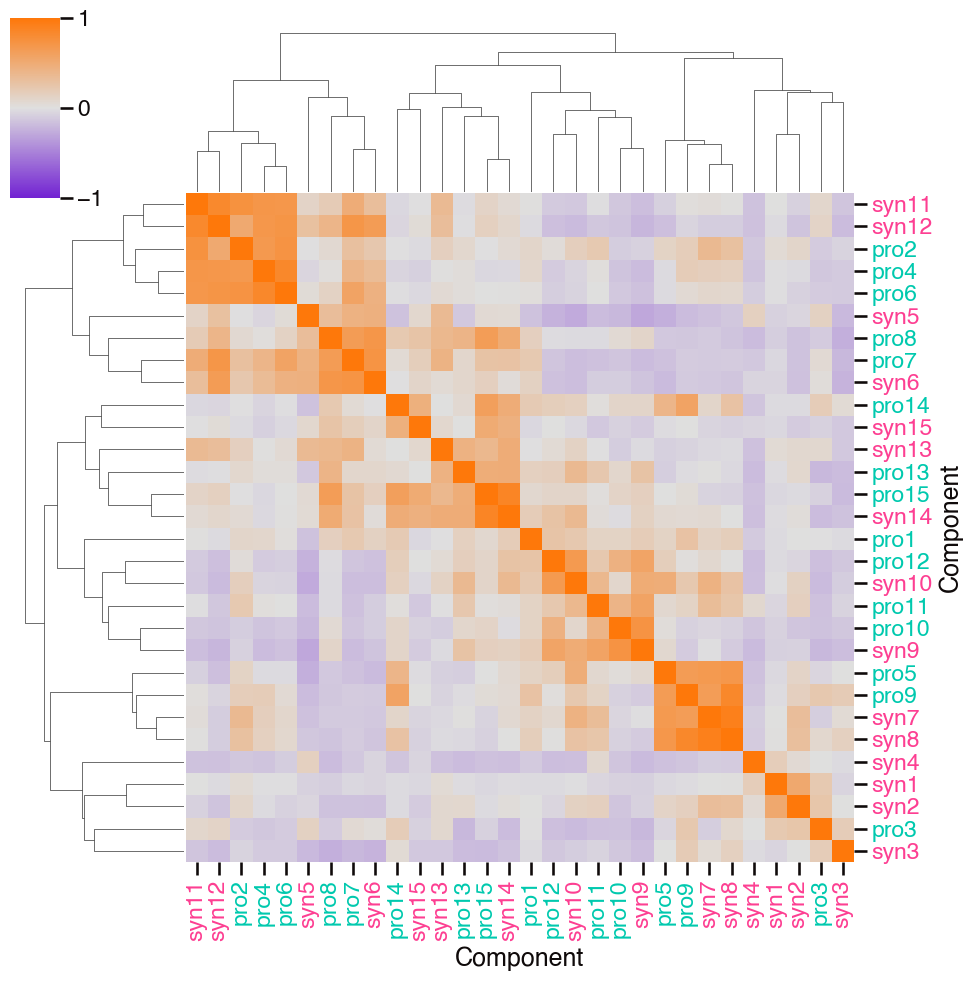

In [8]:
# sample weights correlations

# make joint sample weights df
joint_sampleweights_df = pd.merge(
    pro_sample_df, syn_sample_df, left_index=True, right_index=True, how='outer').fillna(0)

# make correlation matrix
sim_df = pd.DataFrame(
    joint_sampleweights_df.corr(), 
    index=joint_sampleweights_df.columns, 
    columns=joint_sampleweights_df.columns
)

# make heatmap
g = sns.clustermap(
    sim_df, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, 
    xticklabels=True, 
    yticklabels=True
)
# color ticks by pro/syn
for tick_axis in [g.ax_heatmap.axes.get_xticklabels(), g.ax_heatmap.axes.get_yticklabels()]: 
    for tick in tick_axis:
        if tick._text in pro_clusters:
            tick.set_color(sns.color_palette()[2])
        elif tick._text in syn_clusters:
            tick.set_color(sns.color_palette()[3])
# save figure
g.savefig('sampleweights-correlation-heatmap.png')


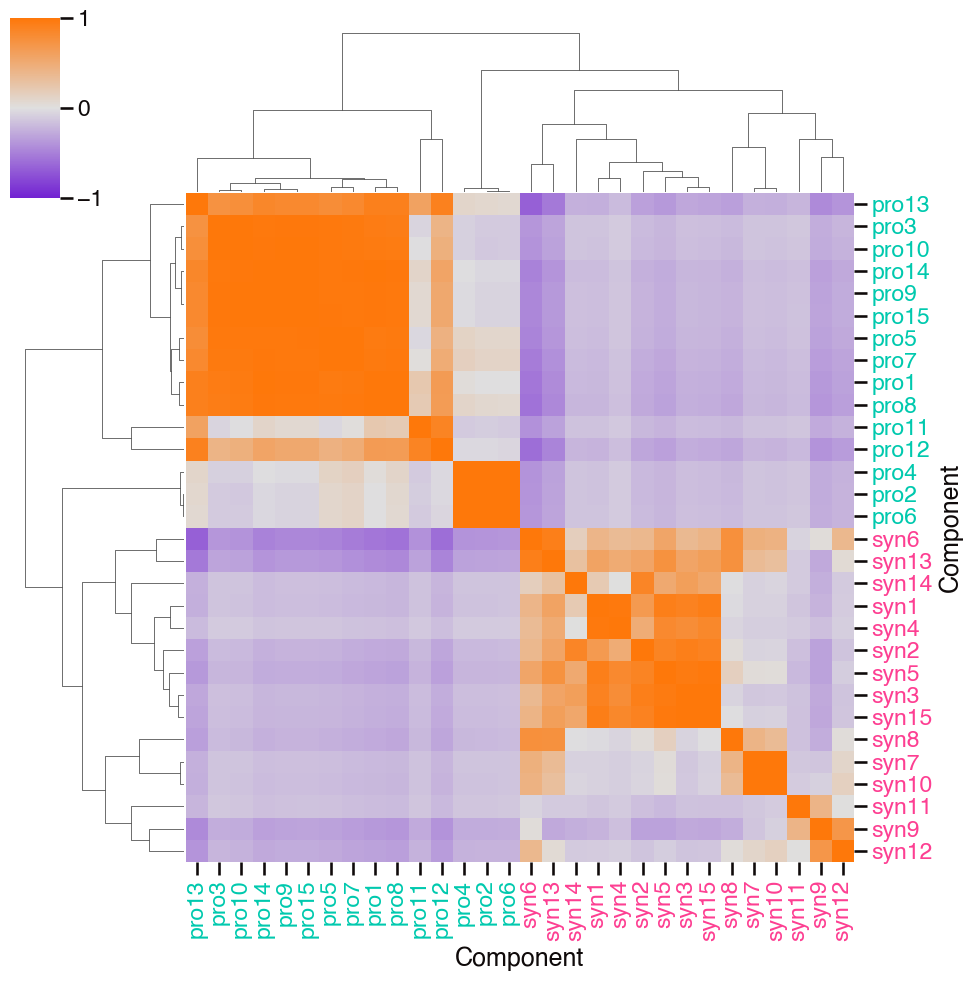

In [9]:
# taxon weights correlation

# make joint taxon weights df
joint_taxonweights_df = pd.merge(
    pro_taxon_df, syn_taxon_df, left_index=True, right_index=True, how='outer').fillna(0)

# make correlation matrix
sim_df = pd.DataFrame(
    joint_taxonweights_df.corr(), 
    index=joint_taxonweights_df.columns, 
    columns=joint_taxonweights_df.columns
)

# make heatmap
g = sns.clustermap(
    sim_df, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, 
    xticklabels=True, 
    yticklabels=True
)
# color ticks by pro/syn
for tick_axis in [g.ax_heatmap.axes.get_xticklabels(), g.ax_heatmap.axes.get_yticklabels()]: 
    for tick in tick_axis:
        if tick._text in pro_clusters:
            tick.set_color(sns.color_palette()[2])
        elif tick._text in syn_clusters:
            tick.set_color(sns.color_palette()[3])
# save figure
g.savefig('taxonweights-correlation-heatmap.png')


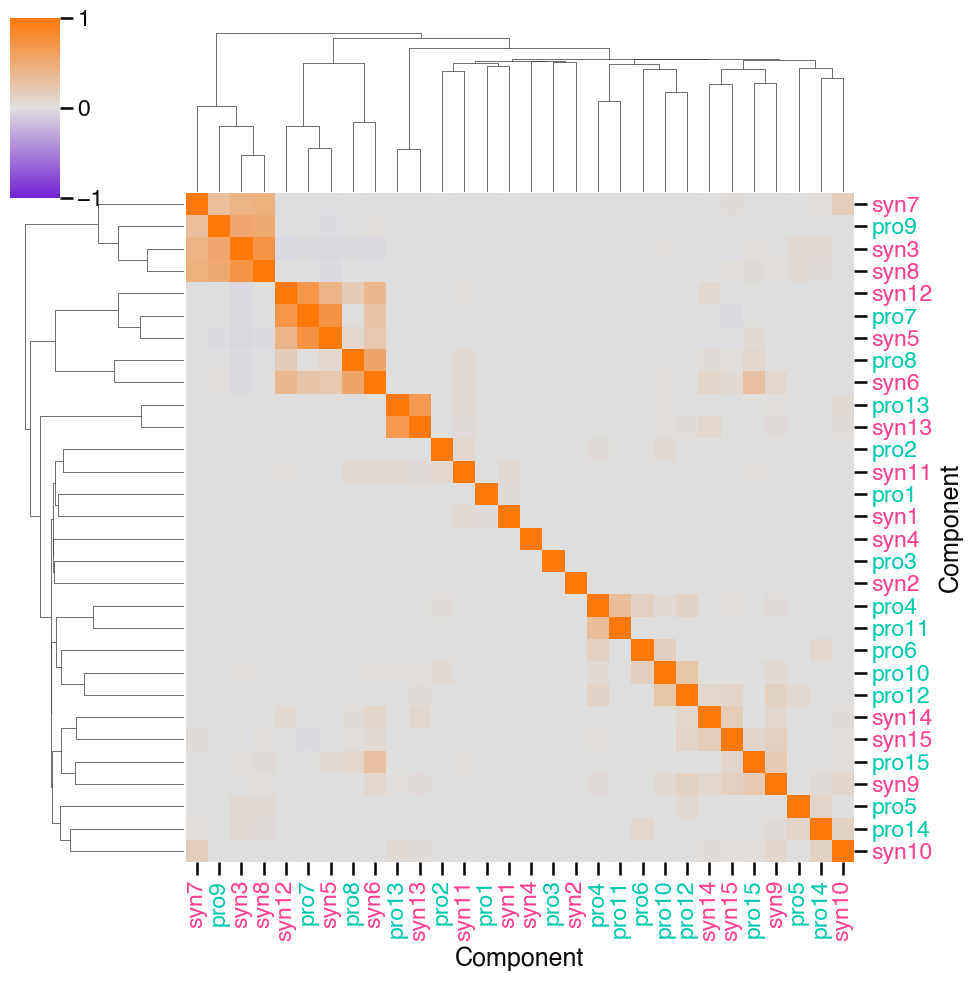

In [10]:
# sample weights correlation

# make joint gene weights df
joint_geneweights_df = pd.merge(
    pro_gene_df, syn_gene_df, left_index=True, right_index=True, how='outer').fillna(0)

# make correlation matrix
sim_df = pd.DataFrame(
    joint_geneweights_df.corr(), 
    index=joint_geneweights_df.columns, 
    columns=joint_geneweights_df.columns
)

# make heatmap
g = sns.clustermap(
    sim_df, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, 
    xticklabels=True, 
    yticklabels=True
)
# color ticks by pro/syn
for tick_axis in [g.ax_heatmap.axes.get_xticklabels(), g.ax_heatmap.axes.get_yticklabels()]: 
    for tick in tick_axis:
        if tick._text in pro_clusters:
            tick.set_color(sns.color_palette()[2])
        elif tick._text in syn_clusters:
            tick.set_color(sns.color_palette()[3])
# save figure
g.savefig('geneweights-correlation-heatmap.png')


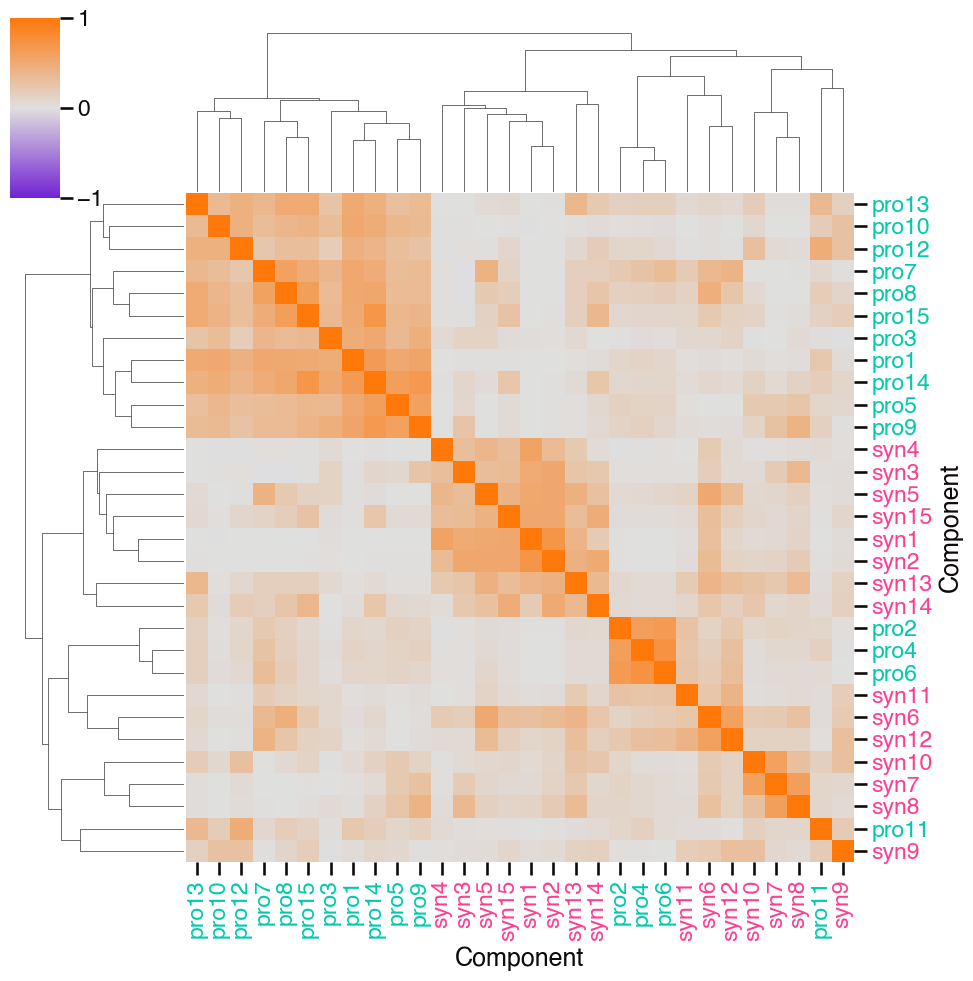

In [11]:
# concatenated sample, taxon, and gene weights

all_weights_df = pd.concat([
    joint_sampleweights_df, joint_taxonweights_df, joint_geneweights_df]
)

# generate matrix of pairwise cosine similarities
sim_df = pd.DataFrame(
    all_weights_df.corr(), 
    index=all_weights_df.columns, columns=all_weights_df.columns
)

# make heatmap
g = sns.clustermap(
    sim_df, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, 
    xticklabels=True, 
    yticklabels=True
)
# color ticks by pro/syn
for tick_axis in [g.ax_heatmap.axes.get_xticklabels(), g.ax_heatmap.axes.get_yticklabels()]: 
    for tick in tick_axis:
        if tick._text in pro_clusters:
            tick.set_color(sns.color_palette()[2])
        elif tick._text in syn_clusters:
            tick.set_color(sns.color_palette()[3])
g.savefig('concatenatedweights-correlation-heatmap.png')


# Combined figure

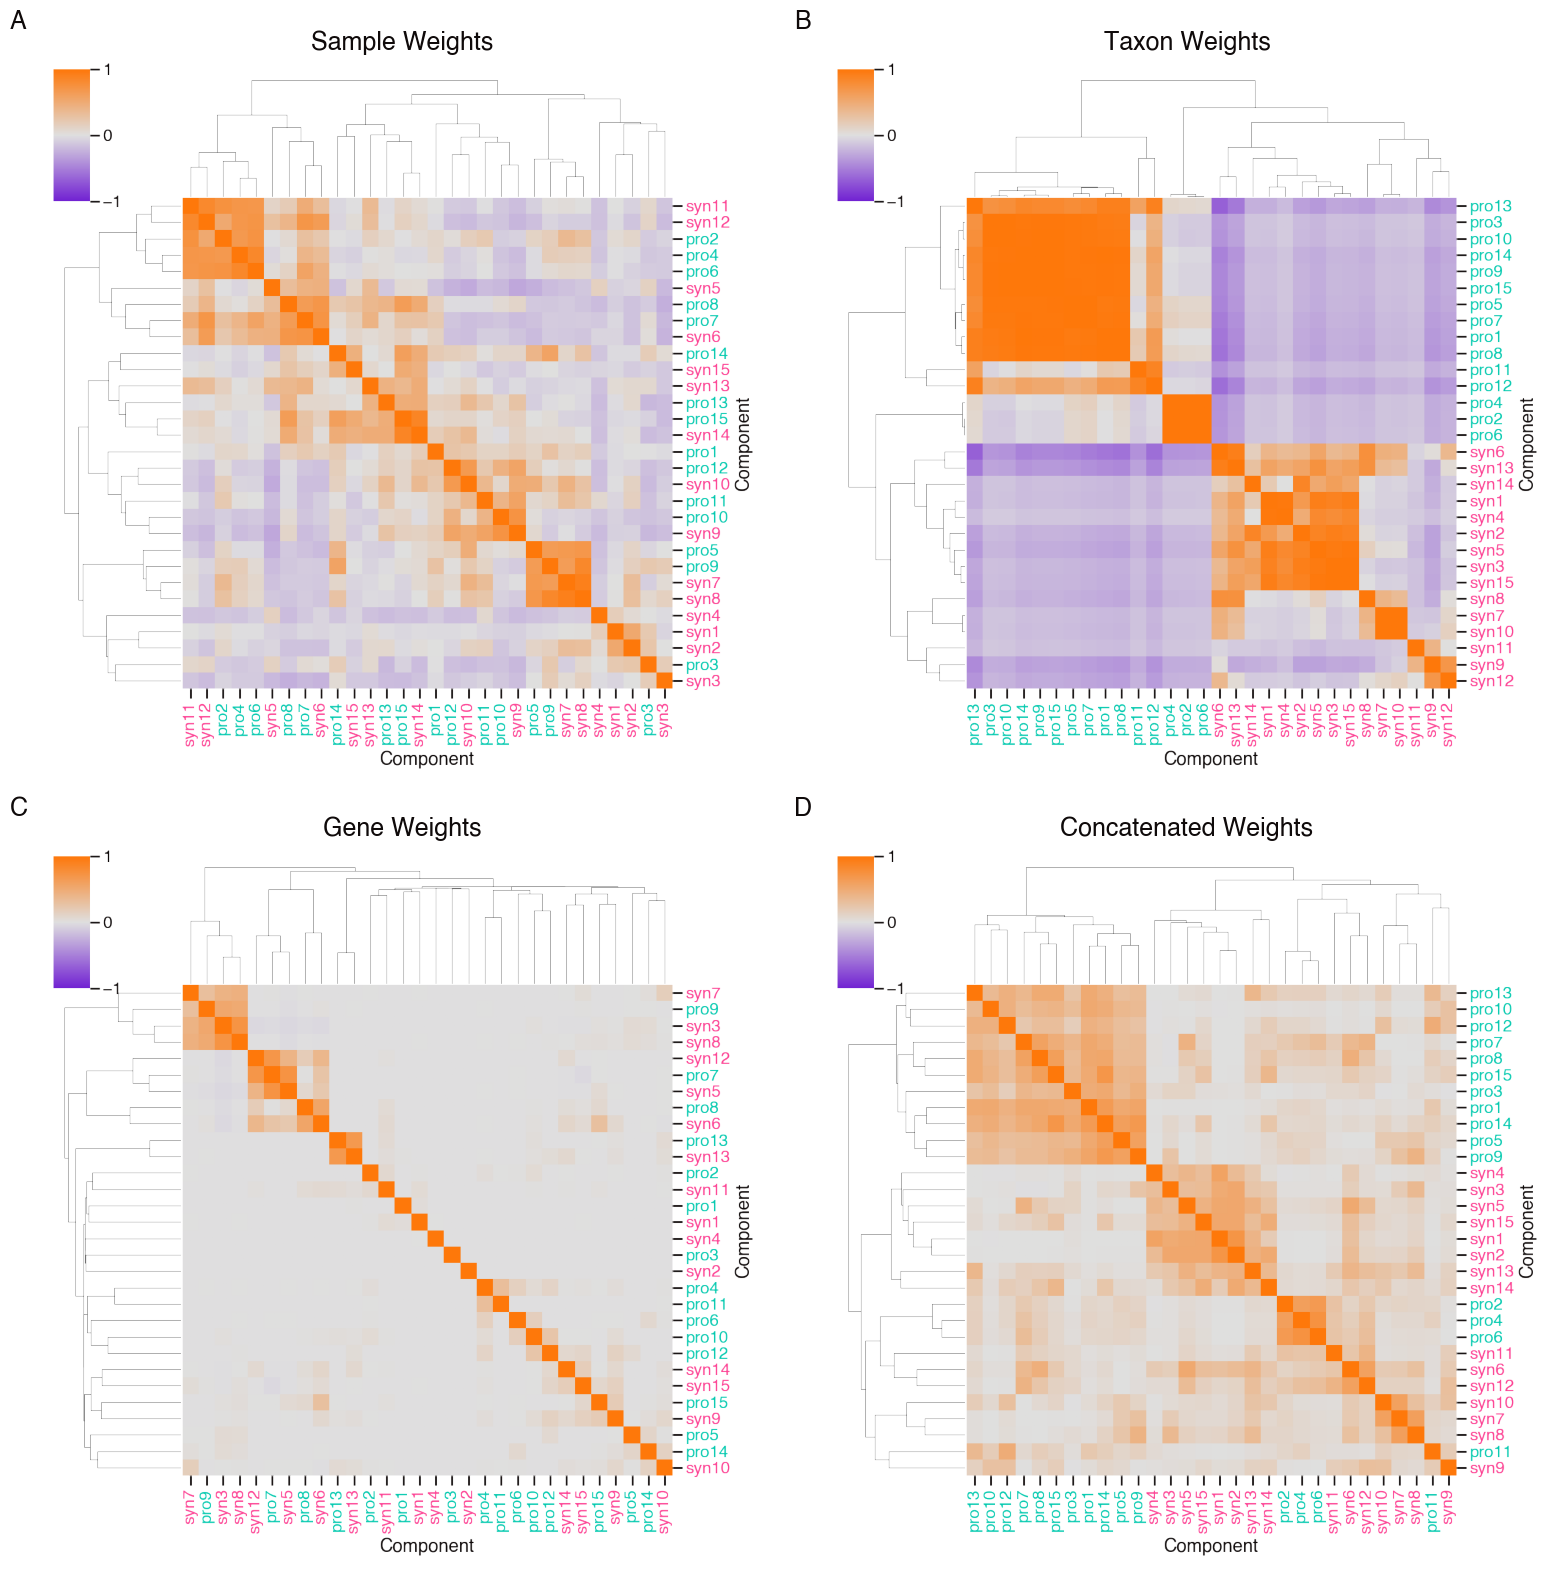

In [12]:
# combine figures as subplots

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 18, 'annotation_clip': False
}

for i, mode in enumerate(['sample', 'taxon', 'gene', 'concatenated']):
    axes.ravel()[i].imshow(mpimg.imread('{}weights-correlation-heatmap.png'.format(mode)))
    axes.ravel()[i].set(title='{} Weights'.format(mode.capitalize()))
    axes.ravel()[i].annotate({0: 'A', 1: 'B', 2: 'C', 3: 'D'}[i], xy=(-0.05, 1.05), **annot_kwgs)

# turn off x and y axis
[ax.set_axis_off() for ax in axes.ravel()]

# clean up & save figure
fig.tight_layout()
fig.savefig('weight-correlation-heatmaps.png', bbox_inches='tight')
plt.show()


# diel peak analysis
### _Prochlorococcus_

In [13]:
# set up data
syn_sample_df = syn_ds.SampleWeight.median(dim=['Bootstrap', 'Replicate']).to_series().reset_index()
syn_sample_df = pd.merge(
    syn_sample_df, 
    sample_df[['SampleName', 'TimeClass', 'TimeFraction', 'Datetime', 'Dataset', 'SampleGroup', 'Year']], 
    on='SampleName', how='left'
).sort_values('TimeFraction')

syn_sample_df[['SampleName', 'TimeFraction']].drop_duplicates()

,SampleName,TimeFraction
852,G3.DIEL.NS.S4C25.15m,0.06
585,G3.DIEL.NS.S4C15.15m,0.12
1028,G3.DIEL.NS.S4C3.15m,0.14
396,G2.SURF.NS.S18C1.15m,0.15
395,G2.SURF.NS.S17C1.15m,0.16
...,...,...
328,G3.DIEL.NS.S4C21.15m,0.73
322,G3.DIEL.NS.S4C11.15m,0.74
875,G1.SURF.NS.S11C1.15m,0.88
503,G3.DIEL.NS.S4C23.15m,0.89


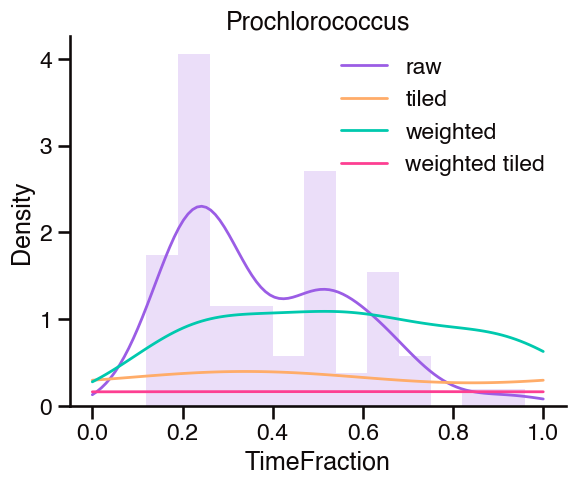

In [14]:
# generate base KDE to account for sampling frequency

# set up data
pro_sample_df = pro_ds.SampleWeight.median(dim=['Bootstrap', 'Replicate']).to_series().reset_index()
pro_sample_df = pd.merge(
    pro_sample_df, 
    sample_df[['SampleName', 'TimeClass', 'TimeFraction', 'Datetime', 'Dataset', 'SampleGroup', 'Year']], 
    on='SampleName', how='left'
).sort_values('TimeFraction')

# pull out unique sample times
pro_sample_time_df = pro_sample_df[['SampleName', 'TimeFraction']].drop_duplicates()
# tile sample times to account for 24 hour cycle
pro_tiled_sample_times = pd.concat([
    pro_sample_time_df['TimeFraction'] - 1, # day before
    pro_sample_time_df['TimeFraction'], # actual sample times
    pro_sample_time_df['TimeFraction'] + 1 # day after
]).reset_index(drop=True)

# build KDE based off of sampling times
pro_raw_kernel = gaussian_kde(pro_sample_time_df['TimeFraction'])

# tile sample times to account for 24 hour cycle
pro_tiled_sample_times = pd.concat([
    pro_sample_time_df['TimeFraction'] - 1, # day before
    pro_sample_time_df['TimeFraction'], # actual sample times
    pro_sample_time_df['TimeFraction'] + 1 # day after
]).reset_index(drop=True)

# try it with tiled sample times
pro_raw_tiled_kernel = gaussian_kde(pro_tiled_sample_times)

# see how well inverse of raw kernel corrects for uneven sampling 
pro_weighted_kernel = gaussian_kde(pro_sample_time_df['TimeFraction'], weights=(1 / pro_raw_kernel(pro_sample_time_df['TimeFraction'])))
# see how well inverse of raw tiled kernel corrects for uneven sampling 
pro_weighted_tiled_kernel = gaussian_kde(pro_tiled_sample_times, 
                                     weights=(1 / pro_raw_kernel(pro_tiled_sample_times)))

# build figure to compare weighted and unweighted 
fig, ax = plt.subplots()
sns.histplot(pro_sample_time_df['TimeFraction'], stat='density', bins=12, alpha=0.2, ax=ax)
values = np.linspace(0, 1, num=100)
for i, kernel in enumerate([pro_raw_kernel, pro_raw_tiled_kernel, pro_weighted_kernel, pro_weighted_tiled_kernel]):
    sns.lineplot(x=values, y=kernel(values), label=['raw', 'tiled', 'weighted', 'weighted tiled'][i], ax=ax)
plt.title('Prochlorococcus')
plt.show()


pro1: kde max at 18:40
pro2: kde max at 5:05
pro3: kde max at 21:05
pro4: kde max at 10:54
pro5: kde max at 16:43
pro6: kde max at 5:34
pro7: kde max at 5:34
pro8: kde max at 6:18
pro9: kde max at 20:07
pro10: kde max at 5:20
pro11: kde max at 5:05
pro12: kde max at 6:18
pro13: kde max at 6:03
pro14: kde max at 19:52
pro15: kde max at 7:01


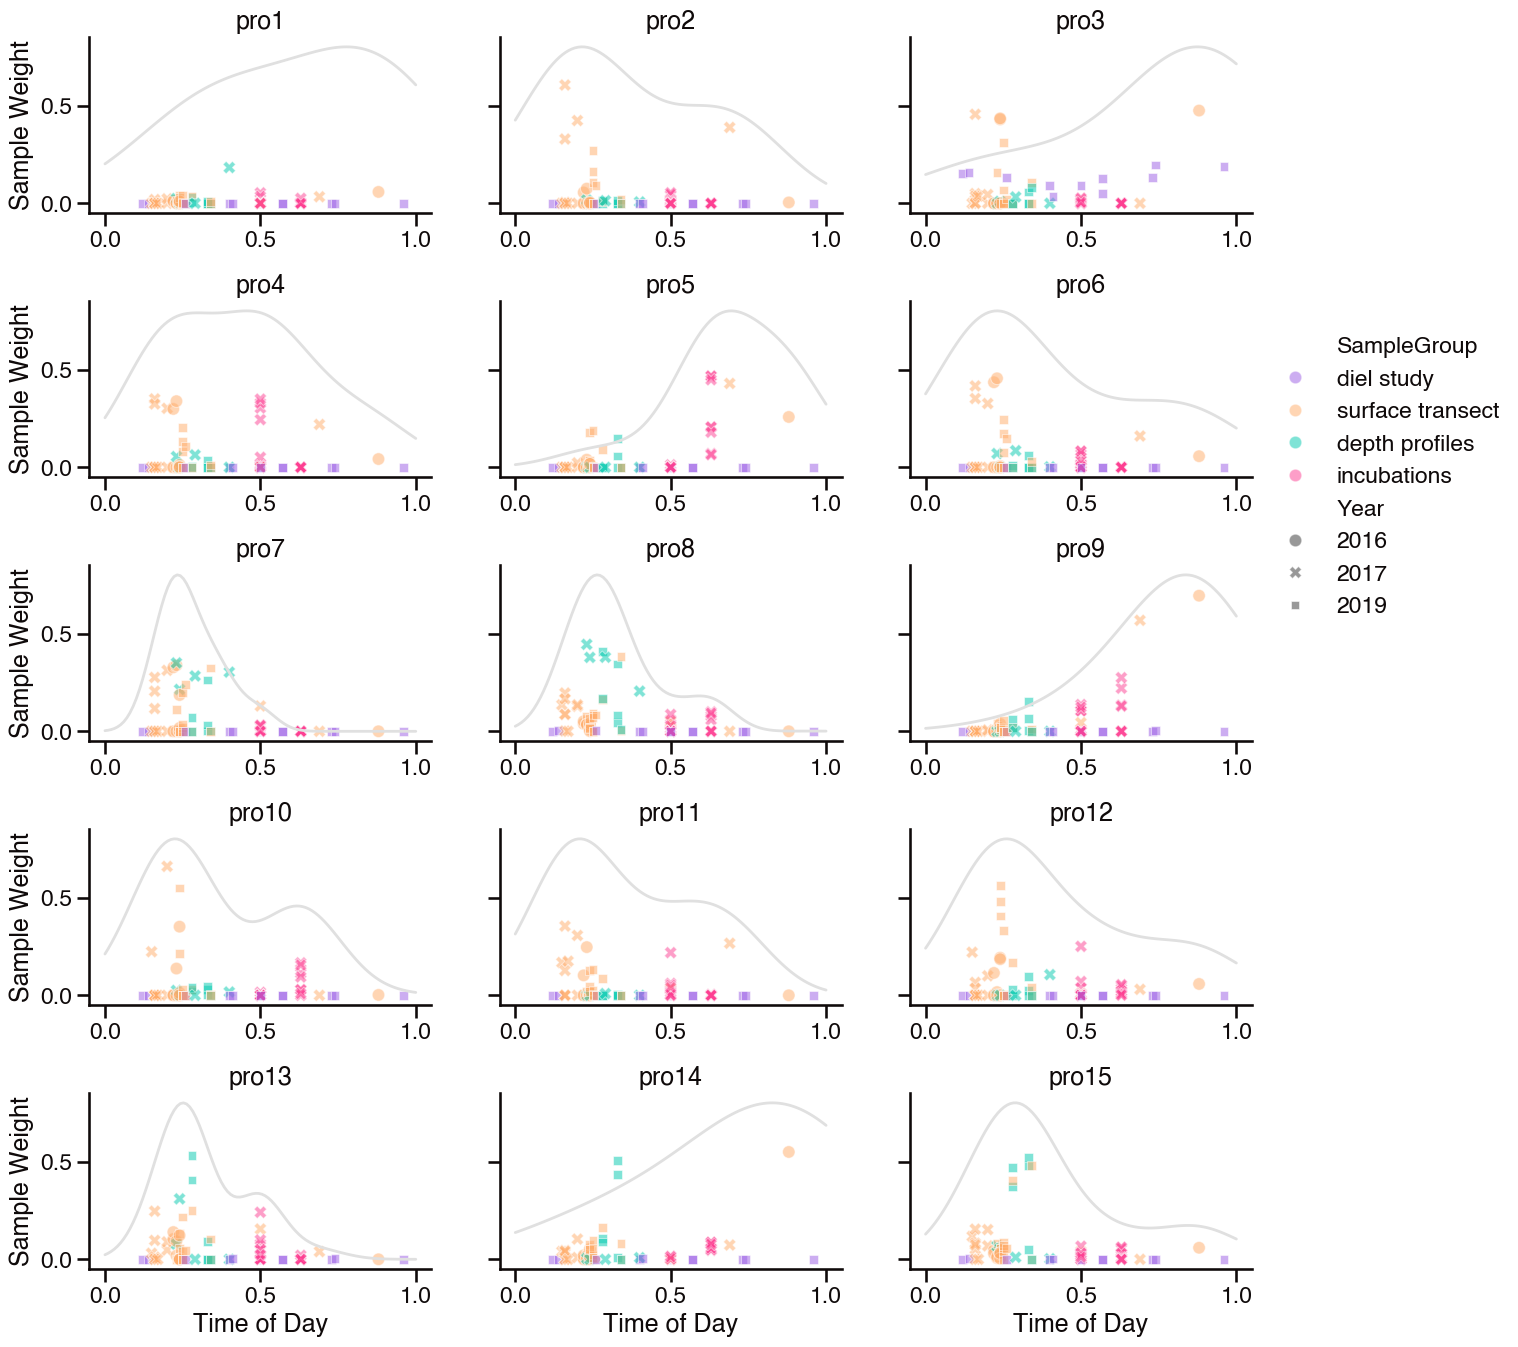

In [15]:
# plot each cluster's diel profile in pro data

# set up figure
rows = 5
cols = 3
clusters = [int(c[3:]) for c in pro_clusters]
data_df = pro_sample_df
raw_kernel = pro_raw_kernel
sample_weight_range = (-0.05, 0.85)
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
fig, axes = plt.subplots(
    rows, cols, figsize=(15, 16), sharex=False, sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.2}
)

# plot each component
for i in range(rows * cols):
    row = i // cols
    col = i % cols
    axis = axes[row][col]
    if i < len(clusters):
        component = clusters[i]
    else:
        # remove subplot
        fig.delaxes(axis)
    # select data
    plot_df = data_df[data_df['Component'] == component]
    # calculate weighted kde
    weighted_kernel = gaussian_kde(plot_df['TimeFraction'], weights=(plot_df['SampleWeight'] * (1 / raw_kernel(plot_df['TimeFraction']))))
    values = np.linspace(0, 1, num=100)
    max = np.max(weighted_kernel(values))
    max_hour = 24 * values[np.argmax(weighted_kernel(values))]
    print(f"pro{component}: kde max at {int(max_hour)}:{int(max_hour % 1 * 60):02}")
    sns.lineplot(
        x=values, 
        y=weighted_kernel(values) / max * (sample_weight_range[1] - 0.05), # normalize so peak is in same range as sample range
        err_style=None, 
        color=neutral_color, 
        ax=axis, 
        legend=False
    )
    sns.scatterplot(
        data=plot_df, 
        x='TimeFraction', 
        y='SampleWeight',
        hue='SampleGroup', 
        style='Year', 
        zorder=1, 
        alpha=0.5, 
        ax=axis, 
        legend=((row == 1) & (col == (cols - 1)))
    )
    # set legend location
    if ((row == 1) & (col == (cols - 1))):
        axis.legend(loc='center left', bbox_to_anchor=[1, 0])
    # set labels and such
    if len(clusters)-cols <= i < len(clusters):
        xlabel = 'Time of Day'
    else:
        xlabel = ''
    if col == 0:
        ylabel = 'Sample Weight'
    else:
        ylabel = ''
    axis.set(xlabel=xlabel, ylabel=ylabel, ylim=sample_weight_range, title='pro{}'.format(component))
    
# save figure
fig.savefig('pro-diel-peaks.png', bbox_inches='tight')


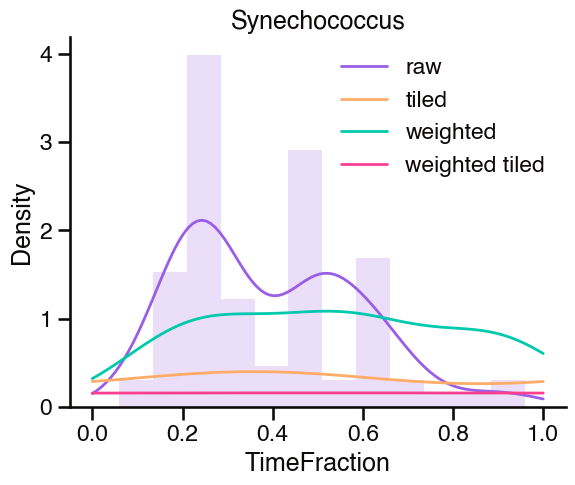

In [16]:
# generate base KDE to account for sampling frequency

# set up data
syn_sample_df = syn_ds.SampleWeight.median(dim=['Bootstrap', 'Replicate']).to_series().reset_index()
syn_sample_df = pd.merge(
    syn_sample_df, 
    sample_df[['SampleName', 'TimeClass', 'TimeFraction', 'Datetime', 'Dataset', 'SampleGroup', 'Year']], 
    on='SampleName', how='left'
).sort_values('TimeFraction')

# pull out unique sample times
syn_sample_time_df = syn_sample_df[['SampleName', 'TimeFraction']].drop_duplicates()

# build KDE based off of sampling times
syn_raw_kernel = gaussian_kde(syn_sample_time_df['TimeFraction'])

# tile sample times to account for 24 hour cycle
syn_tiled_sample_times = pd.concat([
    syn_sample_time_df['TimeFraction'] - 1, # day before
    syn_sample_time_df['TimeFraction'], # actual sample times
    syn_sample_time_df['TimeFraction'] + 1 # day after
]).reset_index(drop=True)

# try it with tiled sample times
syn_raw_tiled_kernel = gaussian_kde(syn_tiled_sample_times)

# see how well inverse of raw kernel corrects for uneven sampling 
syn_weighted_kernel = gaussian_kde(syn_sample_time_df['TimeFraction'], weights=(1 / syn_raw_kernel(syn_sample_time_df['TimeFraction'])))
# see how well inverse of raw tiled kernel corrects for uneven sampling 
syn_weighted_tiled_kernel = gaussian_kde(syn_tiled_sample_times, 
                                     weights=(1 / syn_raw_kernel(syn_tiled_sample_times)))

# build figure to compare weighted and unweighted 
fig, ax = plt.subplots()
sns.histplot(syn_sample_time_df['TimeFraction'], stat='density', bins=12, alpha=0.2, ax=ax)
values = np.linspace(0, 1, num=100)
for i, kernel in enumerate([syn_raw_kernel, syn_raw_tiled_kernel, syn_weighted_kernel, syn_weighted_tiled_kernel]):
    sns.lineplot(x=values, y=kernel(values), label=['raw', 'tiled', 'weighted', 'weighted tiled'][i], ax=ax)
plt.title('Synechococcus')
plt.show()


pro1: kde max at 6:03
pro2: kde max at 19:23
pro3: kde max at 20:07
pro4: kde max at 6:32
pro5: kde max at 6:18
pro6: kde max at 5:49
pro7: kde max at 16:00
pro8: kde max at 18:25
pro9: kde max at 5:05
pro10: kde max at 5:49
pro11: kde max at 4:36
pro12: kde max at 5:20
pro13: kde max at 6:03
pro14: kde max at 7:01
pro15: kde max at 7:45


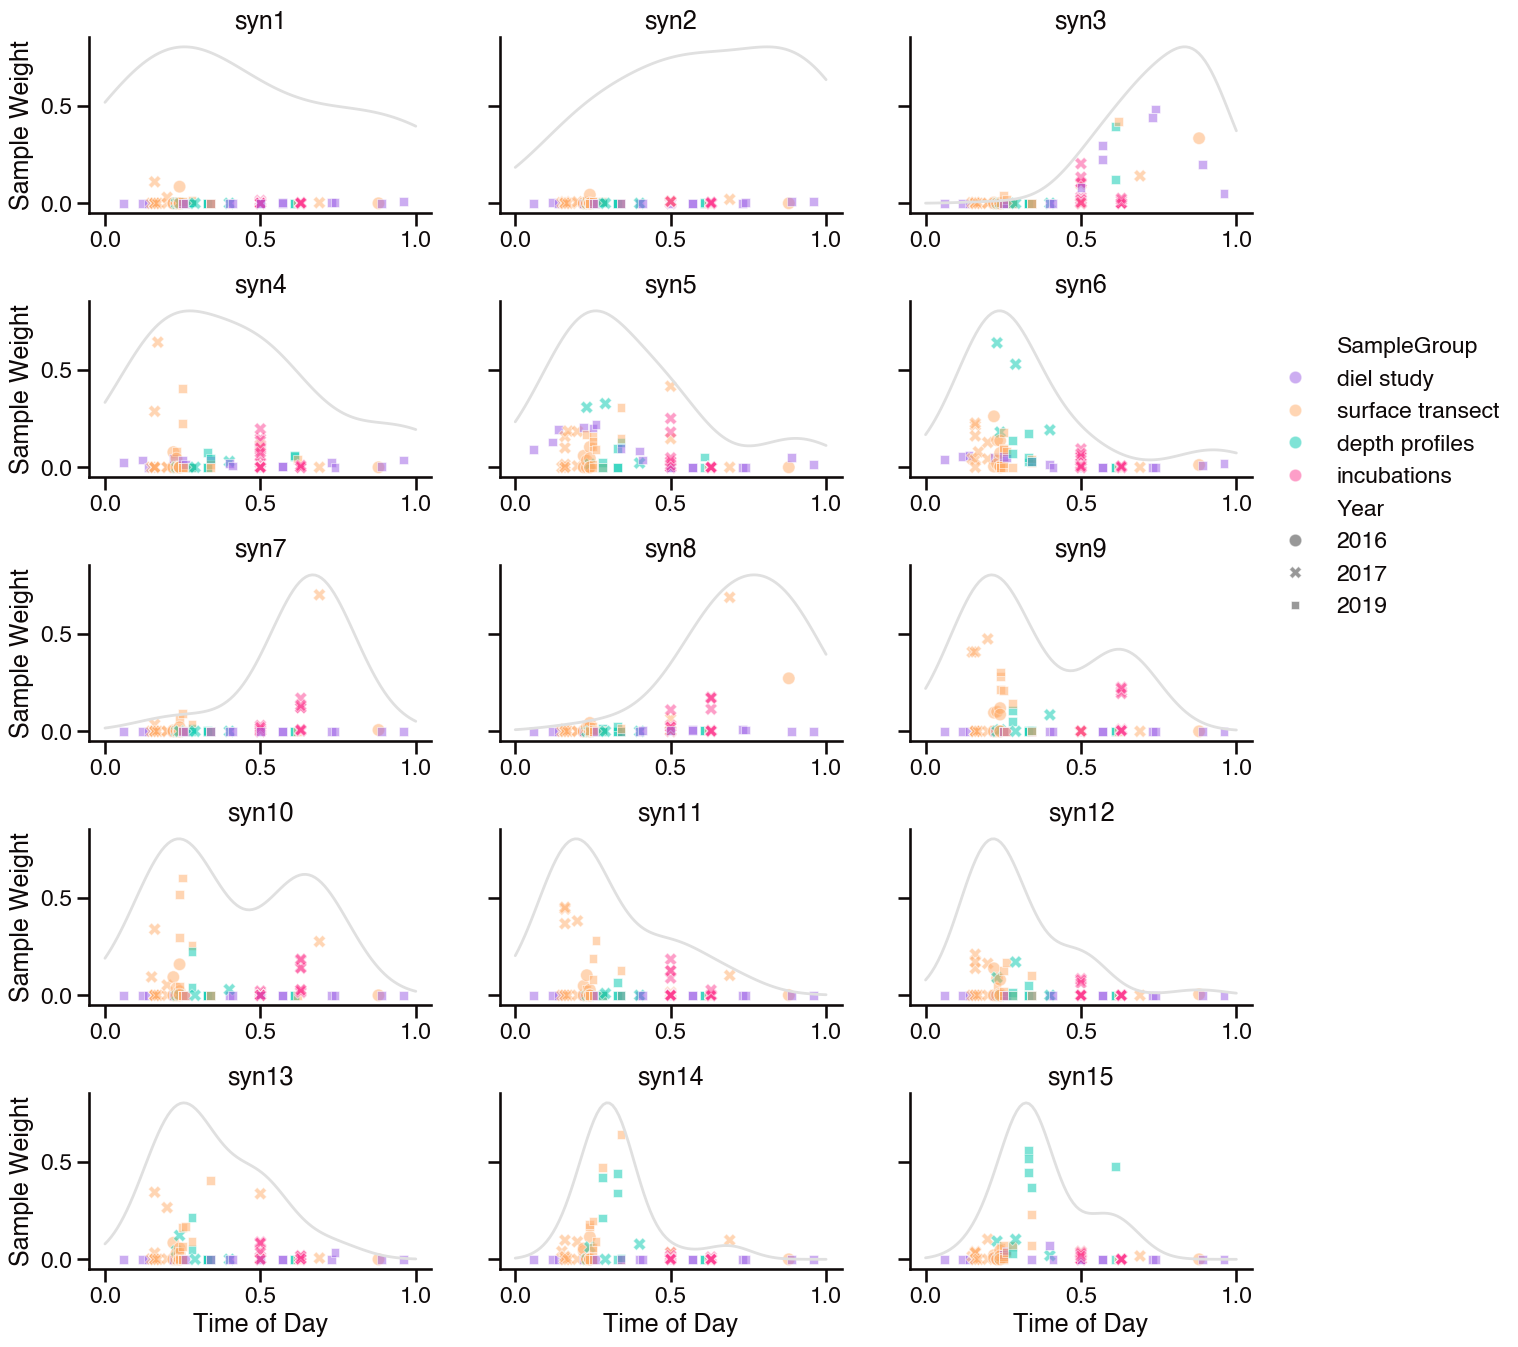

In [17]:
# plot each cluster's diel profile in pro data

# set up figure
rows = 5
cols = 3
clusters = [int(c[3:]) for c in pro_clusters]
data_df = syn_sample_df
raw_kernel = syn_raw_kernel
sample_weight_range = (-0.05, 0.85)
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
fig, axes = plt.subplots(
    rows, cols, figsize=(15, 16), sharex=False, sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.2}
)

# plot each component
for i in range(rows * cols):
    row = i // cols
    col = i % cols
    axis = axes[row][col]
    if i < len(clusters):
        component = clusters[i]
    else:
        # remove subplot
        fig.delaxes(axis)
    # select data
    plot_df = data_df[data_df['Component'] == component]
    # calculate weighted kde
    weighted_kernel = gaussian_kde(plot_df['TimeFraction'], weights=(plot_df['SampleWeight'] * (1 / raw_kernel(plot_df['TimeFraction']))))
    values = np.linspace(0, 1, num=100)
    max = np.max(weighted_kernel(values))
    max_hour = 24 * values[np.argmax(weighted_kernel(values))]
    print(f"pro{component}: kde max at {int(max_hour)}:{int(max_hour % 1 * 60):02}")
    sns.lineplot(
        x=values, 
        y=weighted_kernel(values) / max * (sample_weight_range[1] - 0.05), # normalize so peak is in same range as sample range
        err_style=None, 
        color=neutral_color, 
        ax=axis, 
        legend=False
    )
    sns.scatterplot(
        data=plot_df, 
        x='TimeFraction', 
        y='SampleWeight',
        hue='SampleGroup', 
        style='Year', 
        zorder=1, 
        alpha=0.5, 
        ax=axis, 
        legend=((row == 1) & (col == (cols - 1)))
    )
    # set legend location
    if ((row == 1) & (col == (cols - 1))):
        axis.legend(loc='center left', bbox_to_anchor=[1, 0])
    # set labels and such
    if len(clusters)-cols <= i < len(clusters):
        xlabel = 'Time of Day'
    else:
        xlabel = ''
    if col == 0:
        ylabel = 'Sample Weight'
    else:
        ylabel = ''
    axis.set(xlabel=xlabel, ylabel=ylabel, ylim=sample_weight_range, title='syn{}'.format(component))
    
# save figure
fig.savefig('syn-diel-peaks.png', bbox_inches='tight')


# component characterization figure

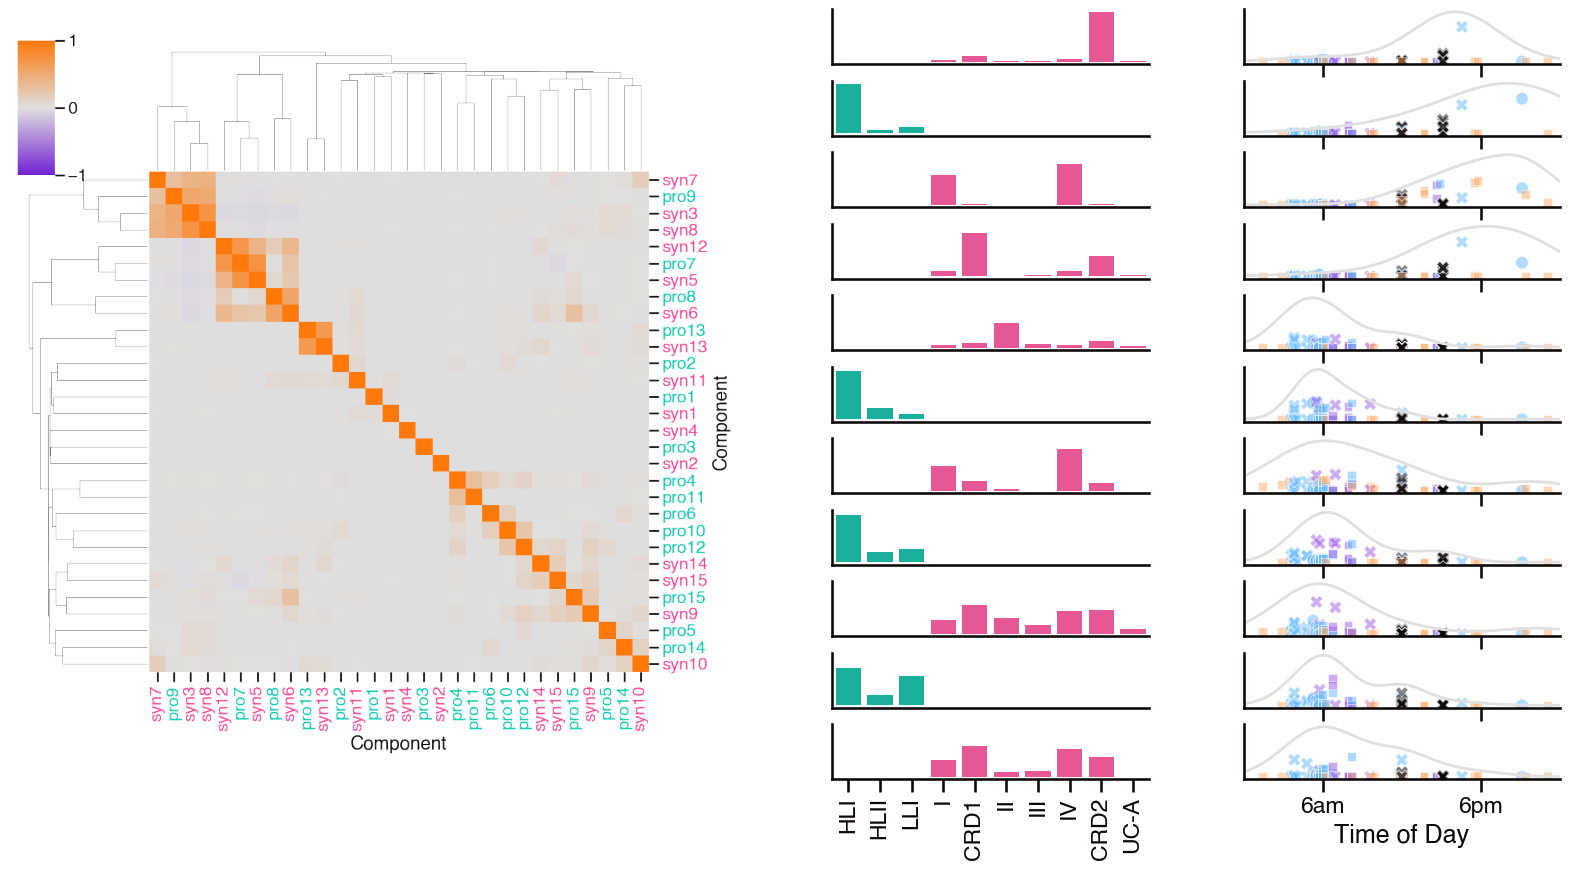

In [32]:
# make combined comparison figure

selected_clusters = ['syn7', 'pro9', 'syn3', 'syn8', 'syn12', 'pro7', 'syn5', 'pro8', 'syn6', 'pro13', 'syn13']
n_clusters = len(selected_clusters)
sample_weight_range = (-0.05, 1.05)
fig = plt.figure(figsize=(20, 10))
grid = plt.GridSpec(n_clusters, 4, wspace=.3, hspace=.3)
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}

# set some common dataset params
clade_order = ['HLI', 'HLII', 'LLI', '5.1B-I', '5.1B-CRD1', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1A-CRD2', '5.1A-UC-A-EnvC']
clade_labels = ['HLI', 'HLII', 'LLI', 'I', 'CRD1', 'II', 'III', 'IV', 'CRD2', 'UC-A']
genus_palette = dict(zip(['Prochlorococcus', 'Synechococcus'], [sns.color_palette()[i] for i in [2, 3]]))
sample_palette = dict(zip(['surface transect', 'incubations', 'depth profiles', 'diel study'], 
                          [sns.color_palette()[i] for i in [7, 4, 0, 1]]))

# plot panel a (clustermap)
ax_a = plt.subplot(grid[:,:2])
ax_a.imshow(mpimg.imread('geneweights-correlation-heatmap.png'.format(mode)))
ax_a.set_axis_off()
# ax_a.annotate('A', xy=(-0.2, 1.15), **annot_kwgs)

# iterate through clusters
for i, cid in enumerate(selected_clusters):
    # plot taxon weights
    ax_b = plt.subplot(grid[i, 2])
    if cid in pro_clusters:
        plot_df = pro_ds.TaxonWeight.sel(Component=int(cid[3:])).to_series().reset_index()
    elif cid in syn_clusters:
        plot_df = syn_ds.TaxonWeight.sel(Component=int(cid[3:])).to_series().reset_index()
    plot_df['Genus'] = {'pro':'Prochlorococcus', 'syn':'Synechococcus'}[cid[:3]]
    # clades = [c for c in clade_order if c in plot_df['Clade'].unique()]
    # sns.boxplot(data=plot_df, x='Clade', y='TaxonWeight', hue='Genus', order=clade_order, hue_order=['Prochlorococcus', 'Synechococcus'], 
    #             palette=genus_palette, fill=False, whis=(5, 95), fliersize=3, legend=False, ax=ax_b)
    sns.barplot(data=plot_df, x='Clade', y='TaxonWeight', hue='Genus', order=clade_order, hue_order=['Prochlorococcus', 'Synechococcus'], 
                palette=genus_palette, estimator='median', errorbar=None, 
                # errorbar=('pi', 90), fill=False, 
                legend=False, ax=ax_b)
    if i == n_clusters-1:
        ax_b.set_xticks(clade_order, clade_labels, rotation=90)
    else:
        ax_b.tick_params(bottom=False, labelbottom=False)
    ax_b.set(xlabel=None, ylabel=None, ylim=[-0.05, 1.05])
    ax_b.tick_params(left=False, labelleft=False)

    # plot sample weights binned by time of day
    ax_c = plt.subplot(grid[i, 3])
    if cid in pro_clusters:
        plot_df = pro_sample_df[pro_sample_df['Component'] == int(cid[3:])]
        raw_kernel = pro_raw_kernel
    elif cid in syn_clusters:
        plot_df = syn_sample_df[syn_sample_df['Component'] == int(cid[3:])]
        raw_kernel = syn_raw_kernel
    # calculate weighted kde
    weighted_kernel = gaussian_kde(plot_df['TimeFraction'], weights=(plot_df['SampleWeight'] * (1 / raw_kernel(plot_df['TimeFraction']))))
    values = np.linspace(0, 1, num=100)
    max = np.max(weighted_kernel(values))
    sns.lineplot(x=values, y=weighted_kernel(values) / max * (sample_weight_range[1] - 0.05), err_style=None, color=neutral_color, 
                 ax=ax_c, legend=False)
    sns.scatterplot(data=plot_df, x='TimeFraction', y='SampleWeight', hue='SampleGroup', palette=sample_palette, 
        style='Year', zorder=1, alpha=0.5, ax=ax_c, legend=False
    )
    ax_c.set_xticks([0.25, 0.75], ['6am', '6pm'])
    if i == n_clusters-1:
        ax_c.set(xlabel='Time of Day', ylabel=None, xlim=[0., 1.], ylim=sample_weight_range)
        ax_c.tick_params(left=False, labelleft=False)
    else:
        ax_c.set(xlabel=None, ylabel=None, xlim=[0., 1.], ylim=sample_weight_range)
        ax_c.tick_params(left=False, labelleft=False, labelbottom=False)

# save figure
fig.savefig('cluster-comparison.png', bbox_inches='tight')
plt.show()
